# Andromeda with Image Data in Jupyter 


### Pre-trained Deep Learning Model for Feature Extraction
**ResNet18 Feature Extractor** extracts features from images at the last convolutional layer, apply average pooling on each feature map, then we got 512 features for each image.


### Interactive Inverse Dimension Reduction 

This notebook implements interactive dimension reduction (DR) for exploratory analysis of high-dimensional data.
It uses a Multi-Dimensional Scaling (MDS) algorithm with a weighted distance metric. It enables both forward and inverse DR interaction. 

**MDS** projects high-dimensional data to a 2D scatterplot. A **weighted distance function** with user-specified weights on each dimension enables alternative projections that emphasize different dimensions. An **Inverse-DR** algorithm learns distance function weights for  user-constructed layouts of the data points.


### CNN Feature Interpretability  

We use **Visual Back Propagation** method to back propagate each feature map, then apply the learned weights from Inverse DR model to the back propogated feature maps, add the final maps together to get the final attention.


### Instructions:

1. Change the variable name of the first file **ImgFolder** to your own image folder path
1. Click "Kernel" in the menu bar --> then click "Restart Kernel and Run All"
1. Proceed to the interactive plots near the bottom
1. There are three kinds of interactions:
    1. **Projection interaction:** Drag images in the projection plot to form user-defined clusters, then click Learn to see learned weights, and click Copy to see the updated projection plot.
    1. **Print Activation Map:** Click the "Print features" button at the bottom of the notebook to see which part of the original image is focused by the underlying model to form user-defined image groups.
1. Be patient, its interactive matplotlib in python and Jupyter!


Based on: 
1. *Self JZ, Dowling M, Wenskovitch J, Crandell I, Wang M, House L, Leman S, North C. Observation-Level and Parametric Interaction for High-Dimensional Data Analysis. ACM Transactions on Interactive Intelligent Systems.  8(2), 2018.* https://infovis.cs.vt.edu/sites/default/files/observation-level-parametric_first_look_version.pdf
2. *Mariusz Bojarski, Anna Choromanska, Krzysztof Choromanski, Bernhard Firner, Larry Jackel, Urs Muller, Karol Zieba. VisualBackProp: efficient visualization of CNNs.* https://arxiv.org/abs/1611.05418v3



In [1]:
%matplotlib notebook

### interactive notebook format is required for the interactive plot

import numpy as np
import pandas as pd
import math
from math import isnan
import random
import os
from os import listdir
from os.path import isfile, join
import cv2
from skimage.transform import resize
import csv
from functools import partial
from tqdm import tqdm

from sklearn.decomposition import PCA
from sklearn.manifold import MDS
import sklearn.metrics.pairwise
from sklearn.metrics import silhouette_score

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.patches import FancyBboxPatch
from matplotlib.widgets import Slider, Button

import ipywidgets as widgets
from ipywidgets import interact, Layout, Button, GridBox, ButtonStyle
from IPython.display import display, clear_output, Image

import ipyplot

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
from torchvision import transforms

## see VisualBackProp.py
import VisualBackProp as VBP

# Load and Pre-process Data

Change the **imgFolder** to load a image dataset.

The image folder structure should be arranged in standard pytorch data loading format i.e: <br>
* root/dog/xxx.png
* root/dog/xxy.png
* root/dog/xxz.png


* root/cat/123.png
* root/cat/nsdf3.png
* root/cat/asd932_.png

In [2]:
## settings
# imgFolder = '/users/huiminhan/Desktop/Lab/InfoVis/Datasets/animal_sample/'
imgFolder = './Images/animal_sample/'
sampleSizePerCat = 100  #sample size for each image category subfolder
imgDisplaySize = 0.4  #default value for image display size, can be interactively adjusted in the UI
total_img = 300  # maximun total number of images to display on the UI
folderName = True  #whether the imgFolder has subfolder for each category. e.g. the fish dataset
load_weights_from_file = False

In [3]:
def get_path(imgFolder, sampleSizePerCat, folderName, max_img_num=50):
    """    
    @parameters:
        imgFolder[str]: path for the image folder. e.g. "/root/" 
        sampleSizePerCat[int]: the number of samples from each subfolder. e.g. 10 images each from "root/cat/"
                          and "root/dog/"
        folderName[boolean]: if structure is: root/cat/123.png then True, if root/123.png then False.
        max_img_num[int]: upper limit for TOTAL image samples
    @return[dict]: a dictionary with image index (used in later dataframe as index as well)
             as key and full path of the image as the value
    """
    imgIdx_path = {}
    totalImg = 0
    for (dirpath, dirnames, filenames) in os.walk(imgFolder):
        sampleCount = 0
        for filename in filenames:
            if filename.lower().endswith('jpg') or filename.lower().endswith(
                    'jpeg') or filename.lower().endswith('png'):
                path = dirpath + '/' + filename
                pattern = extractIdx_pattern(path, folderName)
                imgIdx_path[pattern] = path
                sampleCount += 1
                totalImg += 1
            if sampleCount == sampleSizePerCat or totalImg == max_img_num:
                break
        if totalImg == max_img_num:
            break
    return imgIdx_path


def extractIdx_pattern(path, folderName):
    """
    @parameters:
        path[str]: single image path. e.g. "/root/cat/cat_01.png"
        folderName[boolean]: if structure is: root/cat/123.png then True, if root/123.png then False.
    @return[sts]: given a path(string) of image, extract image index from the path, return the image index string
    """
    if folderName:
        pattern = path.split('/')[-2] + '/' + path.split('/')[-1].split(
            '.')[-2]
    else:
        pattern = path.split('/')[-1].split('.')[-2]
    return pattern


def data_loader(imgIdx_path):
    """
    @parameters:
        imgIdx_path[dict]: a dict get from get_path function storing {image index: full path of the image}
    @return: image loader
    """

    dataset = VBP.FilenameDataset(imgIdx_path.values())
    loader = DataLoader(dataset)
    if loader:
        print("{} images loaded".format(len(loader)))
        return loader
    else:
        print("Invalid path")
        return


def feature_extractor(model, loader, imgIdx_path):
    """
    @parameters:
        model[neuron network]: model used to extract features
        loader: image loader returned from the data_loader function
    @return[dataframe]: a dataframe of extracted features indexing by image index(get from extractIdx_pattern function)
    """
    features = []
    for i, img in zip(range(len(loader)), loader):
        with torch.no_grad():
            x, vis, target_feature_map = model(img)
            features.append(x)
        index = []
        for path in imgIdx_path.values():
            index.append(extractIdx_pattern(path, folderName))
    df = pd.DataFrame(features,
                      columns=[str(i) for i in range(1, 513)],
                      index=index)
    df.index.name = 'Image'
    return df


def df_preprocess(df_image, normalize=True):
    """
    @parameters:
        df_image[dataframe]: image features dataframe
    @return[dataframe]: preprocessed dataframe
    """
    df_image.sort_index(inplace=True)
    df_numeric = df_image.select_dtypes(include='number').drop_duplicates(
    )  #'int32' or 'int64' or 'float32' or 'float64'
    df_category = df_image.select_dtypes(
        exclude='number').drop_duplicates()  #'object'
    ### Z-score normalization
    if normalize:
        normalized_df = (df_numeric - df_numeric.mean()) / df_numeric.std(
        )  # do not normalize animal dataset, all columns are 0-100 scale
        return normalized_df
    return df_numeric

In [4]:
imageIndex_path_dict = get_path(imgFolder,
                                sampleSizePerCat,
                                folderName=folderName,
                                max_img_num=total_img)
img_loader = data_loader(imageIndex_path_dict)
## using the same model in backprop file to make sure
## the forward and backward process happens to the same network
model = VBP.resnet18(pretrained=True).eval()
model_bp = VBP.ResnetVisualizer(model.eval(), weight_list=torch.ones([512]))
df = feature_extractor(model_bp, img_loader, imageIndex_path_dict)
#################################
# the name of the dataframe must be normalized_df, used as global variable later
normalized_df = df_preprocess(df)

30 images loaded


In [5]:
normalized_df.head()

,1,2,3,4,5,6,7,8,9,10,...,503,504,505,506,507,508,509,510,511,512
Image,,,,,,,,,,,,,,,,,,,,,
eagle/07a8e4b860,-0.162496,-0.567235,-0.816496,-0.838552,-0.192350,0.546050,0.273525,0.721096,-0.376110,1.412719,...,-0.760215,-0.324898,-0.499360,-1.009234,-0.835329,0.305386,0.564453,-0.152889,-0.153742,2.596157
eagle/1d28265409,-0.776584,-1.125517,-0.433748,-0.472678,-0.114091,0.688006,-0.054052,1.369560,-0.121901,1.373126,...,-0.639893,0.481204,0.032218,-0.934541,0.105078,-0.659585,-0.655815,-0.739457,-0.943443,2.401620
eagle/3ed0c52621,-0.547234,-0.912961,1.865185,-0.740766,-1.259316,0.528183,2.108206,-0.242519,1.177165,-0.158640,...,-0.012383,0.026048,2.552487,-1.022915,0.616751,3.102926,-0.855537,0.746450,-0.572007,0.275817
eagle/444ad8726f,-0.654709,1.134315,-0.193781,-0.634579,1.405570,1.578226,-0.282481,0.534490,-0.358934,-0.831218,...,1.035201,-0.203325,-1.113216,-0.557624,0.101890,-1.059915,-0.477642,-1.136310,-0.470144,0.305677
eagle/592e4eb886,-0.785357,-0.555415,3.257615,-0.446800,1.429215,1.732477,1.288587,0.449966,1.916344,-0.274997,...,0.256721,0.434823,0.654389,0.060032,2.551979,-0.389575,0.751024,1.270858,0.766765,1.231875


#  Dimension Reduction Model:  Weighted MDS

For DR, we use the Multi-Dimensional Scaling (MDS) algorithm on a weighted data space. **Dimension weights** are applied to the high-dimensional (HD) data.  Weights are normalized to sum to 1, so as to normalize the HD distances to roughly constant size space independent of p.

The **distance function for the high-dimensional (HD) data** is L1 manhattan distance. L1 is good for general purpose use with multi-dimensional quantitative datasets. 

The **distance function for the 2D projected points** is L2 Euclidean distance, which makes sense for human percpetion in the plot.

In [6]:
def distance_matrix_HD(dataHDw):
    """
    Compute the distance matrix for the weighted high-dimensional data using L1 distance function.
    Input HD data should already be weighted.
    
    @parameters:
        dataHDw[pd.df or np.array]: weighted high-dimensional data
    @return[array]: distance matrix for input weighted high-dimensional data
    """
    dist_matrix = sklearn.metrics.pairwise.manhattan_distances(dataHDw)
    return dist_matrix


def distance_matrix_2D(data2D):
    """
    Compute the distance matrix for 2D projected data using L2 distance function.
    
    @parameters: 
        data2D[pd.df or np.array]: projected 2D data
    @return[np.array]: distance matrix for 2D input data
    """
    dist_matrix = sklearn.metrics.pairwise.euclidean_distances(data2D)
    return dist_matrix

**MDS** projects the weighted high-dimensional data to 2D. Tune the algorithm's parameters for performance.

In [7]:
def stress(distHD, dist2D):
    """
    Calculate the MDS stress metric between HD and 2D distances.
    @parameters: 
        distHD[np.array]: distance matrix for high-dimensional data
        dist2D[np.array]: distance matrix for 2D data
    @return[float]: stress value
    """
    s = ((distHD - dist2D)**
         2).sum() / (distHD**2).sum()  # numpy, eliminate sqrt for efficiency
    return s


def compute_mds(dataHDw):
    """
    apply MDS to high-dimensional data to get 2D data
    @parameters:
        dataHDw[pd.df or np.array]: weighted high-dimensional data
    @return[dataframe]: a dataframe of 2D data 
    """
    distHD = distance_matrix_HD(dataHDw)
    ### Adjust these parameters for performance/accuracy tradeoff
    mds = sklearn.manifold.MDS(n_components=2,
                               dissimilarity='precomputed',
                               n_init=10,
                               max_iter=1000,
                               random_state=3)
    # Reduction algorithm happens here:  data2D is n*2 matrix
    data2D = mds.fit_transform(distHD)

    ### Rotate the resulting 2D projection to make it more consistent across multiple runs.
    ### Set the 1st PC to the y axis, plot looks better to spread data vertically with horizontal text labels
    pca = sklearn.decomposition.PCA(n_components=2)
    data2D = pca.fit_transform(data2D)
    data2D = pd.DataFrame(data2D, columns=['y', 'x'], index=dataHDw.index)

    data2D.stress_value = stress(distHD, distance_matrix_2D(data2D))
    return data2D


def dimension_reduction(dataHD, wts):  # dataHD, wts -> data2D (pandas)
    """
    apply weights to high-dimensional data then apply MDS to get 2D data
    @parameters:
        dataHD[pd.df or np.array]: original high-dimensional data
    @return[dataframe]: a dataframe of projected 2D data
    """
    ### Normalize the weights to sum to 1
    wts = wts / wts.sum()

    ### Apply weights to the HD data
    dataHDw = dataHD * wts

    ### DR algorithm
    data2D = compute_mds(dataHDw)

    ### Compute row relevances as:  data dot weights
    ### High relevance means large values in upweighted dimensions
    #     data2D['relevance'] = dataHDw.sum(axis=1)
    return data2D


def get_weights(min_weight, max_weight, index, load_weights_from_file=False):
    """
    initialize weights for high-dimensional data
    @parameters:
        load_weights_from_file[boolean]: whether load weights from a saved csv file or not
    @return[dataframe]: a dataframe of initialized weights (equal for each features if not loaded from a saved csv file)
    """
    if load_weights_from_file:
        weights = pd.read_csv(weights_path)['Weight']
    else:
        # 1.0/len(normalized_df.columns) # initialize to min to make the sliders easier to use.
        weights = pd.Series(init_weight, index=index,
                            name="Weight")  # the current weight list
    return weights

In [8]:
init_weight, min_weight, max_weight = 0.00001, 0.00001, 0.9999
weights = get_weights(min_weight, max_weight, normalized_df.columns)
df_2D = dimension_reduction(normalized_df,
                            weights)  # the current projected data
print("Initialized distance matrix:")
pd.DataFrame(distance_matrix_HD(normalized_df * (weights / weights.sum())),
             columns=normalized_df.index,
             index=normalized_df.index).head(2)

Initialized distance matrix:


Image,eagle/07a8e4b860,eagle/1d28265409,eagle/3ed0c52621,eagle/444ad8726f,eagle/592e4eb886,eagle/72a82a8ef0,eagle/8d33099f2f,eagle/9bc9b116a7,goose/31bd86a5bc,goose/36ebca7932,...,shark/1d7b3a3e30,shark/25c629ddd6,shark/42e0b4ff0a,shark/5b3c8cbcb9,shark/7d65b05fd1,snake/2c5acd90f0,snake/36cc96437a,snake/4bf4f30634,snake/8bdaf65b8a,snake/99b4143227
Image,,,,,,,,,,,,,,,,,,,,,
eagle/07a8e4b860,0.000000,0.738029,1.061073,0.817122,0.838094,0.905160,0.854394,0.578014,0.998679,0.919356,...,1.251975,1.040777,1.082589,1.093165,1.216591,1.159267,1.131813,1.157659,1.181042,1.09138
eagle/1d28265409,0.738029,0.000000,0.983989,0.955206,0.893123,0.954895,0.858688,0.718264,1.040069,1.030958,...,1.385585,1.142538,1.180569,1.213132,1.286365,1.211191,1.213221,1.234892,1.319915,1.16812


# Inverse Dimension-Reduction Learning Algorithm

Computes the inverse-Dimension-Reduction: given input 2D points, compute new weights.
Optimizes the MDS stress function that compares 2D pairwise distances (||$x_i-x_j||$) to weighted HD pairwise distances ($d_{ij}$):
![Stress](https://wikimedia.org/api/rest_v1/media/math/render/svg/7989b3afc0d8795a78c1631c7e807f260d9cfe68)

Technically, we compute the inverse weighted distance function. We shortcut the optimization by eliminating MDS from the process, and assume that the user input 2D distances are actually the desired HD distances, not the 2D distances after re-projection. Thus, given the input (HD) distances, we find weights that would produce these distances in the HD space.

In [9]:
# This method is used to propose a new weight for current column in a smart fashion
def new_proposal(current, step, direction):
    return np.clip(current + direction * step * random.random(), 0.00001,
                   0.9999)


def inverse_DR(dataHD, data2D, curWeights=None):
    """
    @parameters:
        dataHD[pd.df or np.array]: high-dimensional data
        data2D[pd.df or np.array]: projected 2D data
    @return[pd.Series]: new weights  
    """
    dist2D = distance_matrix_2D(data2D)  # compute 2D distances only once
    col_names = dataHD.columns
    dataHD = dataHD.to_numpy()  # use numpy for efficiency
    row, col = dataHD.shape

    if curWeights == None:
        curWeights = np.array([1.0 / col] * col)  # default weights = 1/p
    else:
        curWeights = curWeights.to_numpy()
        curWeights = curWeights / curWeights.sum(
        )  # Normalize weights to sum to 1
    newWeights = curWeights.copy()  # re-use this array for efficiency

    # Initialize state
    flag = [0] * col  # degree of success of a weight change
    direction = [1] * col  # direction to move a weight, pos or neg
    step = [1.0 / col] * col  # how much to change each weight

    dataHDw = dataHD * curWeights  # weighted space, re-use this array for efficiency
    distHD = distance_matrix_HD(dataHDw)
    curStress = stress(distHD, dist2D)
    print('Starting stress =', curStress, 'Processing...')

    MAX = 500  # default setting of the number of iterations

    # Try to minorly adjust each weight to see if it reduces stress
    for i in range(MAX):
        for dim in range(col):
            # Get a new weight for current column
            nw = new_proposal(curWeights[dim], step[dim], direction[dim])

            # Scale the weight list such that it sums to 1
            s = 1.0 + nw - curWeights[dim]  # 1.0 == curWeights.sum()
            np.true_divide(
                curWeights, s,
                out=newWeights)  # transfers to other array, while doing /
            newWeights[dim] = nw / s

            # Apply new weights to HD data
            np.multiply(
                dataHD, newWeights, out=dataHDw
            )  # dataHDw = dataHD * newWeights; efficiently reuses dataHDw array
            distHD = distance_matrix_HD(dataHDw)

            # Get the new stress
            newStress = stress(distHD, dist2D)

            # If new stress is lower, then update weights and flag this success
            if newStress < curStress:
                temp = curWeights
                curWeights = newWeights
                newWeights = temp  # reuse the old array next iteration
                curStress = newStress
                flag[dim] = flag[dim] + 1
            else:
                flag[dim] = flag[dim] - 1
                direction[dim] = -direction[dim]  # Reverse course

            # If recent success, then speed up the step rate
            if flag[dim] >= 5:
                step[dim] = step[dim] * 2
                flag[dim] = 0
            elif flag[dim] <= -5:
                step[dim] = step[dim] / 2
                flag[dim] = 0

    print('Solution stress =', curStress, 'Done.')
    return pd.Series(curWeights, index=col_names, name="Weight")

# Visualization and UI code

Use these functions to create the GUI components in any cell.

## Sliders

In [10]:
def create_size_slider(imgDisplaySize=imgDisplaySize):
    """
    Create image size adjust slider
    @parameters:
        imgDisplaySize[float]: zoom image displayed size
    @return[widgets slider]: return the slize adjustment slider 
    """

    style = {'description_width': 'initial'}
    size_slider = widgets.FloatSlider(
        min=0,
        max=1,
        step=0.01,
        value=imgDisplaySize,
        description='Adjust image size',
        style=style,
        continuous_update=False,
        readout_format='.5f',
    )
    size_slider.style.handle_color = 'lightblue'
    return size_slider

## Checkbox

In [11]:
def create_checkbox(ax):
    """
    @return: create the checkbox to toggle the images and titles(image index in the dataframe)  
    """
    title_checkbox = widgets.Checkbox(False,
                                      description='Toggle Titles',
                                      indent=False,
                                      layout=Layout(width='20%',
                                                    height='20px'))
    image_checkbox = widgets.Checkbox(True,
                                      description='Toggle Images',
                                      indent=False,
                                      layout=Layout(width='20%',
                                                    height='20px'))

    def title_check_clicked(x):
        image = image_checkbox.value
        draw_plot(ax, df_2D, x, image, imgSize=size_slider.value)

    interact(title_check_clicked, x=title_checkbox)

    def image_clicked(x):
        title = title_checkbox.value
        draw_plot(ax, df_2D, title, x, imgSize=size_slider.value)

    interact(image_clicked, x=image_checkbox)
    return title_checkbox, image_checkbox

## Buttons

In [12]:
def create_size_slider_button(size_slider, ax):
    """
    @parameters:
        size_slider: 
        ax:
    @return[button]: return image size adjust button
    """
    size_apply_button = widgets.Button(
        description='Apply Slider Size',
        style=ButtonStyle(button_color='lightblue'))

    def size_slider_button_clicked(change):
        toggle_image = hasattr(plot_ax.dragpoint.artists[0], 'ab')
        toggle_tittle = ax.dragpoint.artists[0].text.get_text() != ''
        draw_plot(ax,
                  df_2D,
                  toggle_tittle,
                  toggle_image,
                  imgSize=size_slider.value)

    size_apply_button.on_click(size_slider_button_clicked)
    return size_apply_button


## reset button
def create_reset_buttons(ax, sliders=None):
    """
    @return[button]: return reset plot button  
    """
    reset_button = widgets.Button(description='Reset Plot',
                                  style=ButtonStyle(button_color='salmon'))

    def reset_button_clicked(change):
        if sliders:
            for s in sliders:
                s.value = init_weight 
        global weights, df_2D, normalized_df  # Update weights and df_2D globals
        weights = pd.Series(init_weight,
                            index=normalized_df.columns,
                            name="Weight")
        df_2D = dimension_reduction(normalized_df, weights)
        toggle_image = hasattr(plot_ax.dragpoint.artists[0], 'ab')
        toggle_tittle = ax.dragpoint.artists[0].text.get_text() != ''
        # Redraw the plot
        draw_plot(ax,
                  df_2D,
                  toggle_tittle,
                  toggle_image,
                  imgSize=size_slider.value)

    reset_button.on_click(reset_button_clicked)

    return reset_button


## Visual Back Prop button
def create_visual_explainations(ax):
    """
    @return[button]: return button and plot Visual Backprop map
    """

    print_button = widgets.Button(description='Visual Explainations')
    print_output = widgets.Output()

    def transformer():
        """
        transformer for image dataset, using the ImageNet mean and std since Resnet18 is pre-trained on ImageNet
        """
        transformer = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        return transformer

    def plot_VBP_map(loader, model_bp):
        if len(loader) > 0:
            # set number of columns (use 3 to demonstrate the change)
            ncols = 2
            # calculate number of rows
            nrows = len(loader)

            plt.figure(figsize=(6, 10))
            for i, img in zip(range(len(loader)), loader):
                with torch.no_grad():
                    x, vis, feature_map = model_bp(img)
                vis = vis[0].numpy().transpose(1, 2, 0)[:, :, 0]
                vis = np.interp(vis, [vis.min(), vis.max()], [0, 1])
                img = img[0].numpy().transpose(1, 2, 0)
                img = np.interp(img, [img.min(), img.max()], [0, 1])
                plt.subplot(nrows, ncols, 2 * i + 1)
                plt.imshow(img, interpolation='bilinear')
                plt.axis('off')
                plt.subplot(nrows, ncols, 2 * (i + 1))
                plt.imshow(vis, cmap='viridis', interpolation='bilinear')
                plt.axis('off')
            plt.tight_layout()
            plt.show()
        else:
            print('Select points in the plot to see details here')

    def feature_button_clicked(change):
        print_output.clear_output()
        # Get list of selected points and print their source data values
        c_index = [c.index for c in ax.circles if c.selected]
        s_index = list(df.iloc[c_index, :].index)
        weights_list = torch.tensor(np.float32(weights))
        files = []
        for i in s_index:
            files.append(imageIndex_path_dict[i])

        ## this transformer is for pre-trained model on ImageNet dataset
        transform = transformer()
        ds = VBP.FilenameDataset(files, transform)
        loader = DataLoader(ds)
        global model_bp
        with print_output:
            plot_VBP_map(loader, model_bp)

    print_button.on_click(feature_button_clicked)
    display(print_button)
    display(print_output)
    return print_button, print_output


## inverse DR button
def create_inverse_button(ax, fig_show=False):
    """
    @return[button]: return 'Learn New Weights' and 'Update Projections' buttons
    """
    inverse_button = widgets.Button(
        description='Learn New Weights',
        style=ButtonStyle(button_color='darkseagreen'))
    copy_button = widgets.Button(
        description='Update Projections',
        style=ButtonStyle(button_color='darkseagreen'))

    def inverse_button_clicked(change):
        # Check minimum number of points moved
        n = sum([i.selected for i in ax.dragpoint.artists])
        if n < 2:
            print(
                'Need to select or move at least 2 points in the plot first.')
            return

        # Get selected data points
        data2Dnew = pd.DataFrame(
            [c.center for c in ax.dragpoint.artists if c.selected],
            columns=['x', 'y'],
            index=[c.label for c in ax.dragpoint.artists if c.selected])
        global normalized_df
        dataHDpart = normalized_df.loc[data2Dnew.index]

        # Learn new weights
        global weights
        weights = inverse_DR(dataHDpart, data2Dnew)

    inverse_button.on_click(inverse_button_clicked)

    def copy_button_clicked(change):

        global df_2D, size_slider, normalized_df

        df_2D = dimension_reduction(normalized_df, weights)
        toggle_image = hasattr(plot_ax.dragpoint.artists[0], 'ab')
        toggle_tittle = ax.dragpoint.artists[0].text.get_text() != ''

        draw_plot(ax, df_2D, toggle_tittle, toggle_image, size_slider.value)

    copy_button.on_click(copy_button_clicked)

    if fig_show:
        fig, ax = plt.subplots(
            figsize=(5, 7))  # reserve a fig for the weights bar chart
        weights.sort_index(ascending=False).plot.barh(ax=ax1)
        ax1.set_xlabel("Weight")
        fig.tight_layout()

    return inverse_button, copy_button

## Draggable Dimension-Reduction 2D Plot

In [13]:
# Handles mouse drag interaction events in the plot, users can select and drag points.
class DraggablePoints(object):
    def __init__(self, ax, artists):
        self.ax = ax
        self.artists = artists
        self.current_artist = None
        self.last_selected = None
        ax.selected_text.set_text('Selected: none')
        self.offset = (0, 0)
        # Set up mouse listeners
        ax.figure.canvas.mpl_connect('pick_event', self.on_pick)
        ax.figure.canvas.mpl_connect('motion_notify_event', self.on_motion)
        ax.figure.canvas.mpl_connect('button_release_event', self.on_release)

    def on_pick(self, event):
        # When point is clicked on (mouse down), select it and start the drag
        if self.current_artist is None:  # clicking on overlapped points sends multiple events
            self.last_selected = event.artist.index  # event.ind
            self.current_artist = event.artist
            event.artist.selected = True
            event.artist.savecolor = event.artist.get_facecolor()
            event.artist.set_facecolor('green')
            #event.artist.set_alpha(1.0)
            self.ax.selected_text.set_text("Selected: " + event.artist.label)
            x0, y0 = event.artist.center
            self.offset = (x0 -
                           event.mouseevent.xdata), (y0 -
                                                     event.mouseevent.ydata)

    def on_motion(self, event):
        # When dragging, check if point is selected and valid mouse coordinates
        if (self.current_artist
                is not None) and (event.xdata is not None) and (event.ydata
                                                                is not None):
            # Drag the point and its text label
            dx, dy = self.offset
            self.current_artist.center = x0, y0 = event.xdata + dx, event.ydata + dy
            self.current_artist.text.set_position(
                (x0 + self.current_artist.radius, y0))
            if self.current_artist.ab:
                self.current_artist.ab.xybox = (x0, y0)

    def on_release(self, event):
        # When mouse is released, stop the drag
        self.current_artist = None

In [14]:
def create_plot(data2D, title=False):
    """
    @parameters:
        data2D[pd.df or np.array]: projected 2D data
        title[boolean]: toggle tittle or not 
    @return[AxesSubplot]: plotting axes
    """
    # Initialize DR plot figure
    fig, ax = plt.subplots(figsize=(10, 10), dpi=80)
    ax.selected_text = ax.figure.text(0,
                                      0.005,
                                      'Selected: none',
                                      wrap=True,
                                      color='green')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.figure.tight_layout()

    # Store state data:
    ax.dragpoint = None
    draw_plot(ax, data2D, title)

    return ax


def image_preprocessing(imgIndex):
    """
    segment images if background is black
    @parameters:
        imgIndex[str]: image index
    @return[np.array(image)]: processed image
    """

    global imageIndex_path_dict
    path = imageIndex_path_dict[imgIndex]
    up_width = 224
    up_height = 224
    up_points = (up_width, up_height)
    src = cv2.imread(path, 1)
    src = cv2.resize(src, up_points, interpolation=cv2.INTER_LINEAR)
    tmp = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)
    _, alpha = cv2.threshold(tmp, 0, 255, cv2.THRESH_BINARY)
    b, g, r = cv2.split(src)
    rgba = [r, g, b, alpha]
    processed_img = cv2.merge(rgba, 4)

    return processed_img


def draw_plot(ax, data2D, title=False, image=True, imgSize=imgDisplaySize):
    """
    @parameters:
        ax[AxesSubplot]: plot ax
        data2D[dataframe]: projected 2D dataframe
        title[boolean]: whether toggle title or not
        image[boolean]: whether toggle image or not
        imgSize[float]: zoom parameter of OffsetImage, determine size of displaying images
    """
    labels_df = data2D.index.to_series().apply(lambda x: x.split('/')[0])
    data2D['label'] = labels_df
    label_list = list(set(data2D['label']))
    conversion_dict = {
        k: v
        for k, v in zip(label_list, range(len(label_list)))
    }
    data2D['label_num'] = data2D['label'].replace(conversion_dict)
    ax.clear()
    wid = max(data2D.x.max() - data2D.x.min(),
              data2D.y.max() - data2D.y.min())  # max range of x,y axes
    if not image:
        cnorm = mpl.colors.Normalize(vmin=data2D.label_num.min(),
                                     vmax=data2D.label_num.max())

        ax.circles = data2D.apply(axis=1,
                                  func=lambda row: mpl.patches.Circle(
                                      xy=(row.x, row.y),
                                      radius=wid / 70,
                                      alpha=0.95,
                                      label=row.label_num,
                                      color=plt.cm.Set3(cnorm(row.label_num)),
                                      picker=True))
        for i, c in enumerate(ax.circles):
            # Store state data:
            c.index, c.label, c.selected = i, data2D.index[i], False
            # Draw circles and text labels in plot
            ax.add_patch(c)
            if title:
                c.text = ax.text(c.center[0] + c.radius,
                                 c.center[1],
                                 c.label,
                                 color='black')
            else:
                c.text = ax.text(c.center[0] + c.radius,
                                 c.center[1],
                                 "",
                                 color='none')
    else:
        ax.circles = []
        for x0, y0, index in zip(data2D.x, data2D.y, data2D.index):
            ax.circles.append(
                mpl.patches.Circle(xy=(x0, y0),
                                   radius=wid * imgSize / 3,
                                   alpha=0.5,
                                   color='none',
                                   picker=True))

        for i, c in enumerate(ax.circles):
            # Store state data:
            c.index, c.label, c.selected = i, data2D.index[i], False
            # Draw circles and text labels in plot
            ax.add_patch(c)
            processed_img = image_preprocessing(c.label)
            img = OffsetImage(processed_img, zoom=imgSize)
            c.ab = AnnotationBbox(img, (c.center[0], c.center[1]),
                                  frameon=False)
            ax.add_artist(c.ab)
            if title:
                c.text = ax.text(c.center[0] + c.radius,
                                 c.center[1],
                                 c.label,
                                 color='black')
            else:
                c.text = ax.text(c.center[0] + c.radius,
                                 c.center[1],
                                 "",
                                 color='none')

    # Make plot circles draggable
    ax.dragpoint = DraggablePoints(ax, ax.circles)
    # Clean up the plot
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis('equal')

# Interactive Visualization

## Dimension Reduction Plot
This shows the HD data in 2D form, such that **proximity == similarity**, based on the current slider weights.  Distances between points in the plot approximately reflect their distances in the weighted HD data.  Thus points near each other have similar HD data values in the up-weighted dimensions, and points far away have very different HD data values in those dimensions.

Points can be **selected** to highlight in Green and view their details below.  Points can be **dragged** to specify a new projection for learning weights, see below. To reset the plot and clear the selections, click the **Reset** button above.

## Inverse Dimension Reduction
After selecting and/or dragging some points in the DR plot, click the **Learn** button to machine learn new dimension weights that would produce a plot with similar pairwise distances as your plot.  **Only the Green selected points** in the plot are considered when learning new weights. You must select or move at least two points to specify new desired distances. Use this to create your own clusters, and find out what makes some data points similar to or different from others.  The **learned weights** are shown in a bar chart below.

To see the effects of the learned weights, click the **Copy** button to apply the learned weights to the sliders and  make a new DR plot above.

<IPython.core.display.Javascript object>


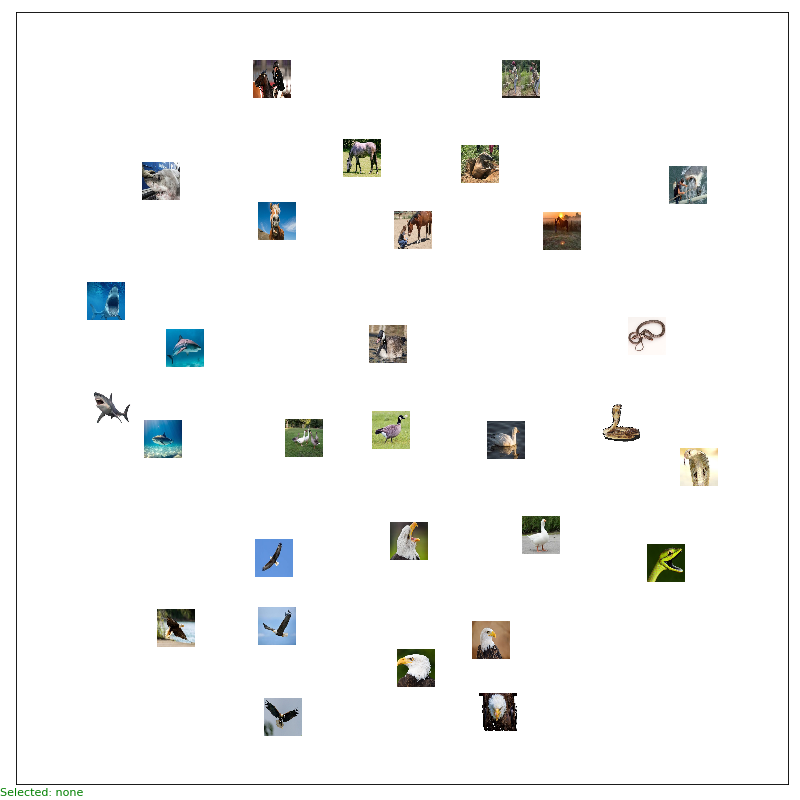

Need to select or move at least 2 points in the plot first.
Starting stress = 0.007517225902131494 Processing...
Solution stress = 0.0 Done.


In [15]:
plot_ax = create_plot(df_2D)
size_slider = create_size_slider()
size_apply_button = create_size_slider_button(size_slider, plot_ax)
learn_new_weights_button, update_projections_button = create_inverse_button(
    plot_ax)
display(widgets.HBox([size_slider, size_apply_button]))
display(
    widgets.HBox([
        learn_new_weights_button, update_projections_button,
        create_reset_buttons(plot_ax)
    ]))

In [16]:
point_attribute = create_checkbox(plot_ax)

interactive(children=(Checkbox(value=False, description='Toggle Titles', indent=False, layout=Layout(height='2…

interactive(children=(Checkbox(value=True, description='Toggle Images', indent=False, layout=Layout(height='20…

##  Image Saliency Map
Click the **Visual Explainations** button below to display the weighted mask captured by the underlying model

In [17]:
attention = create_visual_explainations(plot_ax)

Button(description='Visual Explainations', style=ButtonStyle())

Output()

# Simulation Engine

In [18]:
def Sampler(data_2D, n_sample):
    print('Initial s score is: ',
          silhouette_score(data_2D[['x', 'y']], data_2D['label']))
    df_sample = data_2D.copy()
    df_sample['label'] = df_sample.index.str.split('/').str[:1].str.join('')
    selected_points = df_sample.groupby('label').apply(
        lambda group: group.sample(n_sample))
    selected_points.index = selected_points.index.droplevel(0)
    return selected_points


def InteractionSimulator(sample_data_2D):
    data_HD = normalized_df.loc[sample_data_2D.index]
    data_2D = pd.get_dummies(sample_data_2D['label'])
    #     display(data_2D)
    #     display(pd.DataFrame(distance_matrix_2D(data_2D)*100,index=data_2D.index,columns=data_2D.index,dtype=float))
    wts = inverse_DR(data_HD, data_2D)
    return wts


def EvaluationSimulator(n_control_points, output_file_mark="test"):
    s_score_list = []
    wts_list = []
    for i in tqdm(range(1, n_control_points + 1)):
        sample_df = Sampler(df_2D, n_sample=i)
        wts = InteractionSimulator(sample_df)
        wts.to_csv('./WeightsDirectory/' + str(output_file_mark) +
                   '_iteration_' + str(i) + '.csv',
                   header=True)
        updated_df_2D = dimension_reduction(normalized_df, weights)
        updated_df_2D['label'] = updated_df_2D.index.str.split(
            '/').str[:1].str.join('')
        s_score = silhouette_score(updated_df_2D[['x', 'y']],
                                   updated_df_2D['label'])
        print("Updated s score after dragging: ", s_score)
        s_score_list.append(s_score)
        wts_list.append(wts)
    return s_score_list, wts_list


def create_load_weights_from_file(n_control_points, output_file_mark='animal'):
    load_button = widgets.Button(description="Load weights from file")

    def apply_button_clicked(change):
        # Use the slider values to re compute the DR and redraw the plot
        global weights, df_2D, imageIndex_path_dict
        paths = imageIndex_path_dict.values()
        weights = pd.read_csv('./WeightsDirectory/' + str(output_file_mark) +
                              '_iteration_' + str(n_control_points) +
                              '.csv')['Weight']
        weights.index = normalized_df.columns
        df_2D = dimension_reduction(normalized_df, weights)
        draw_plot(plot_ax, df_2D)

    load_button.on_click(apply_button_clicked)
    display(load_button)

In [19]:
## the following code is for simulation engine
#EvaluationSimulator(3, 'animal')